In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Load the data
sample_id = "IMMUNEX001"
adata = sc.read_10x_h5(f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_008um/filtered_feature_bc_matrix.h5")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 678981 × 18536
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sample_id'

In [2]:
import pandas as pd

# Load coordinates from Space Ranger output (adjust path as needed)
parquet_path = f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_008um/spatial/tissue_positions.parquet"
coords = pd.read_parquet(parquet_path)
display(coords.head())

# Set barcode index if not done
coords.set_index("barcode", inplace=True)

# Join without suffix — no conflict now
adata.obs = adata.obs.join(coords, how="left")
display(adata.obs)

# Keep only bins with spatial coordinates
adata = adata[adata.obs["pxl_row_in_fullres"].notnull()].copy()

# Add to obsm
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values

adata.obs["library_id"] = "IMMUNEX001"
adata.uns["spatial"] = {
    "IMMUNEX001": {
        "images": {"hires": None},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}

adata.obs


,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,s_008um_00000_00000-1,1,0,0,43210.764405,85618.380131
1,s_008um_00000_00001-1,1,0,1,43211.087147,85583.400079
2,s_008um_00000_00002-1,1,0,2,43211.409889,85548.420030
3,s_008um_00000_00003-1,1,0,3,43211.732632,85513.439983
4,s_008um_00000_00004-1,1,0,4,43212.055374,85478.459938


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
s_008um_00269_00526-1,1,269,526,52790.021232,67305.661395
s_008um_00260_00253-1,1,260,253,52387.180507,76852.131799
s_008um_00433_00599-1,1,433,599,58550.248301,64804.901059
s_008um_00266_00304-1,1,266,304,52613.504589,75070.101088
s_008um_00154_00449-1,1,154,449,48742.522362,69962.083408
...,...,...,...,...,...
s_008um_00820_00205-1,1,820,205,71960.841671,78711.310061
s_008um_00655_00060-1,1,655,60,66142.301804,83730.372382
s_008um_00307_00022-1,1,307,22,53956.776562,84947.626948
s_008um_00630_00099-1,1,630,99,65280.336140,82358.091150


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id
s_008um_00269_00526-1,1,269,526,52790.021232,67305.661395,IMMUNEX001
s_008um_00260_00253-1,1,260,253,52387.180507,76852.131799,IMMUNEX001
s_008um_00433_00599-1,1,433,599,58550.248301,64804.901059,IMMUNEX001
s_008um_00266_00304-1,1,266,304,52613.504589,75070.101088,IMMUNEX001
s_008um_00154_00449-1,1,154,449,48742.522362,69962.083408,IMMUNEX001
...,...,...,...,...,...,...
s_008um_00820_00205-1,1,820,205,71960.841671,78711.310061,IMMUNEX001
s_008um_00655_00060-1,1,655,60,66142.301804,83730.372382,IMMUNEX001
s_008um_00307_00022-1,1,307,22,53956.776562,84947.626948,IMMUNEX001
s_008um_00630_00099-1,1,630,99,65280.336140,82358.091150,IMMUNEX001


In [10]:

tls_annotation = pd.read_csv('/scratch/IMMUNEX/data/TLS_ANNOTATIONS/TLSIMMUNEX001.csv')
tls_annotation.columns = ['barcode_8um','TLS']
tls_annotation[['row_8', 'col_8']] = tls_annotation['barcode_8um'].str.extract(r's_008um_(\d+)_(\d+)', expand=True).astype(int)

display(tls_annotation.head())

import pandas as pd
import numpy as np

# adata.obs['TLS'] = 0

# Extract row/col from 8µm barcodes
tls_annotation[['row_8', 'col_8']] = tls_annotation['barcode_8um'].str.extract(r's_008um_(\d+)_(\d+)', expand=True).astype(int)
tls_annotation.index = tls_annotation['barcode_8um']

adata.obs = adata.obs.join(tls_annotation, how="left")

adata.obs.head()

# # Loop over TLS rows where TLS is not NaN (i.e., presence)
# for _, row in tqdm(tls_annotation[tls_annotation['TLS'].notna()].iterrows(), total=tls_annotation['TLS'].notna().sum(), desc="Mapping TLS to 2µm bins"):
#     row_2_start = row['row_8'] * 4
#     row_2_end = row_2_start + 3
#     col_2_start = row['col_8'] * 4
#     col_2_end = col_2_start + 3

#     # Find matching 2µm bins
#     match = (
#         (adata.obs['array_row'] >= row_2_start) & (adata.obs['array_row'] <= row_2_end) &
#         (adata.obs['array_col'] >= col_2_start) & (adata.obs['array_col'] <= col_2_end)
#     )

#     # Set TLS = 1 for matched bins
#     adata.obs.loc[match, 'TLS'] = 1


,barcode_8um,TLS,row_8,col_8
0,s_008um_00269_00526-1,NaN,269,526
1,s_008um_00260_00253-1,NaN,260,253
2,s_008um_00433_00599-1,NaN,433,599
3,s_008um_00266_00304-1,NaN,266,304
4,s_008um_00154_00449-1,NaN,154,449


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,barcode_8um,TLS,row_8,col_8
s_008um_00269_00526-1,1,269,526,52790.021232,67305.661395,IMMUNEX001,200,5.303305,206.0,5.332719,...,51.456311,100.0,100.0,7.0,2.079442,3.398058,s_008um_00269_00526-1,NaN,269.0,526.0
s_008um_00260_00253-1,1,260,253,52387.180507,76852.131799,IMMUNEX001,20,3.044522,22.0,3.135494,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00260_00253-1,NaN,260.0,253.0
s_008um_00433_00599-1,1,433,599,58550.248301,64804.901059,IMMUNEX001,38,3.663562,38.0,3.663562,...,100.000000,100.0,100.0,1.0,0.693147,2.631579,s_008um_00433_00599-1,NaN,433.0,599.0
s_008um_00266_00304-1,1,266,304,52613.504589,75070.101088,IMMUNEX001,32,3.496508,38.0,3.663562,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00266_00304-1,NaN,266.0,304.0
s_008um_00154_00449-1,1,154,449,48742.522362,69962.083408,IMMUNEX001,44,3.806662,45.0,3.828641,...,100.000000,100.0,100.0,4.0,1.609438,8.888889,s_008um_00154_00449-1,NaN,154.0,449.0


In [11]:
idx = adata.obs['TLS'].isna()
adata.obs.loc[idx,'TLS'] = 'NoTLS'

In [12]:
adata.obs["library_id"] = "IMMUNEX001"
adata.uns["spatial"] = {
    "VisiumHD_dummy": {
        "images": {"hires": None},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}


/tmp/ipykernel_3193821/3517567413.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


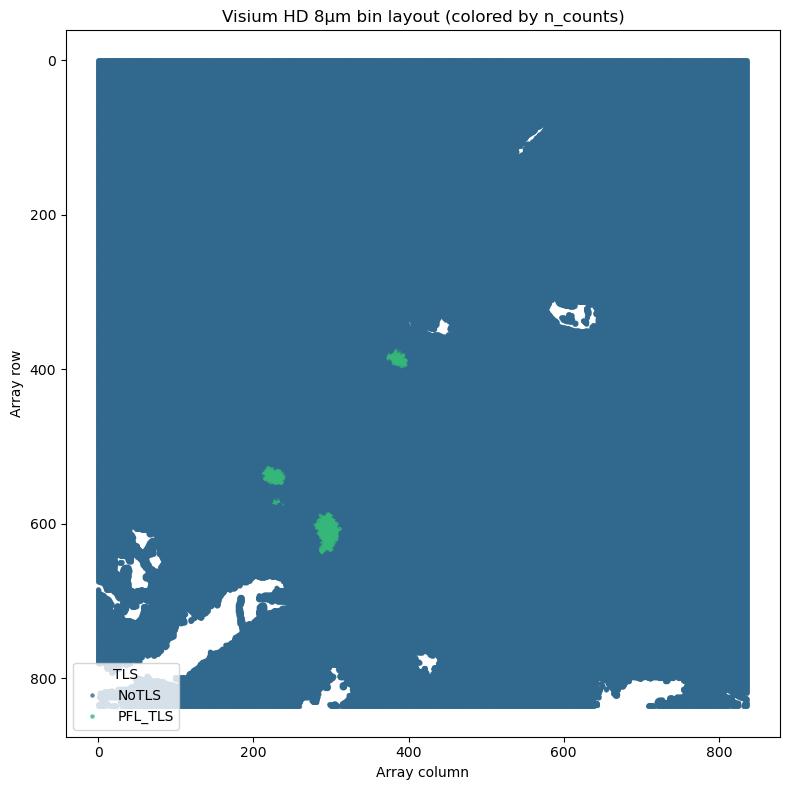

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
df = adata.obs.reset_index()

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df,
    x="array_col",
    y="array_row",
    hue="TLS",
    palette="viridis",
    s=10,
    linewidth=0,
    alpha=0.8
)

plt.gca().invert_yaxis()
plt.axis("equal")
plt.title("Visium HD 8µm bin layout (colored by n_counts)")
plt.xlabel("Array column")
plt.ylabel("Array row")
plt.tight_layout()
plt.show()


In [14]:
# Mitochondrial genes
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


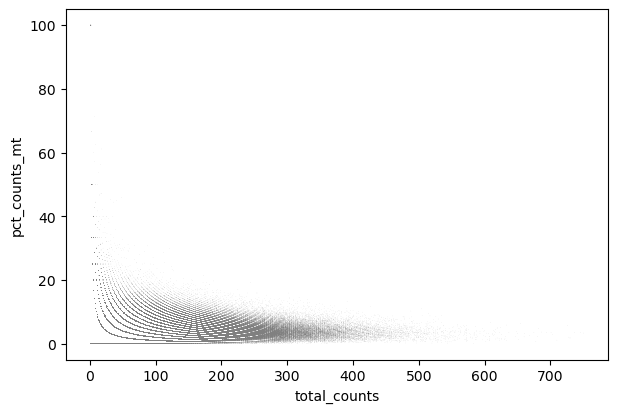

In [15]:
# # Plot QC
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

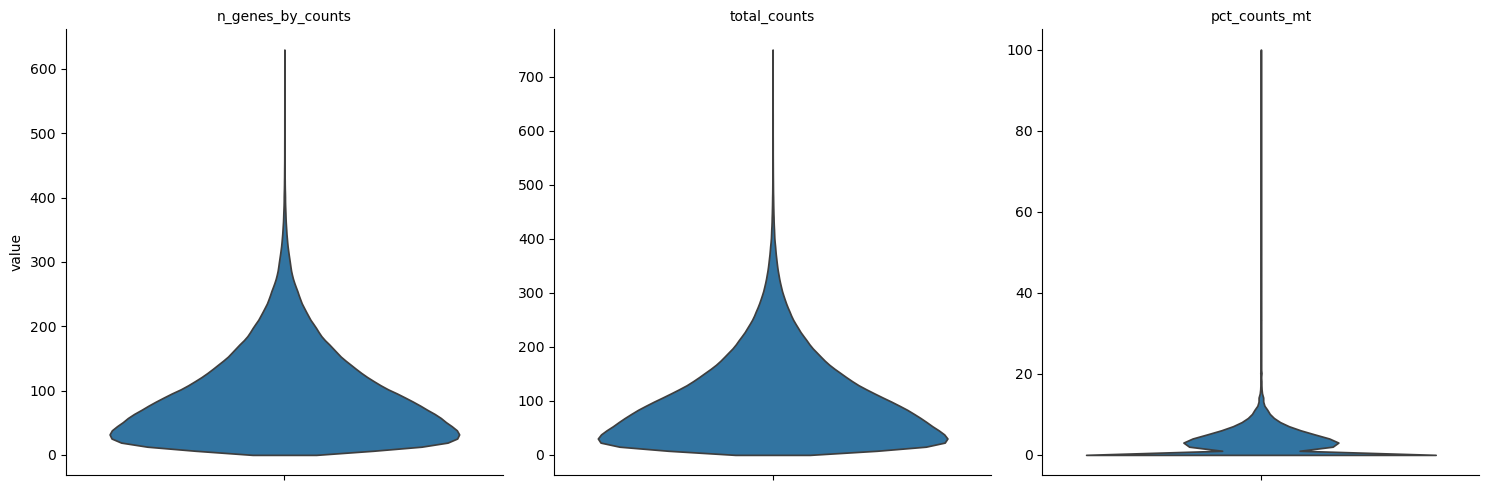

In [16]:
adata.var_names_make_unique()
adata.raw = adata.copy()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=1, multi_panel=True, stripplot=False )


In [17]:
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,barcode_8um,TLS,row_8,col_8
s_008um_00269_00526-1,1,269,526,52790.021232,67305.661395,IMMUNEX001,200,5.303305,206.0,5.332719,...,51.456311,100.0,100.0,7.0,2.079442,3.398058,s_008um_00269_00526-1,NoTLS,269.0,526.0
s_008um_00260_00253-1,1,260,253,52387.180507,76852.131799,IMMUNEX001,20,3.044522,22.0,3.135494,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00260_00253-1,NoTLS,260.0,253.0
s_008um_00433_00599-1,1,433,599,58550.248301,64804.901059,IMMUNEX001,38,3.663562,38.0,3.663562,...,100.000000,100.0,100.0,1.0,0.693147,2.631579,s_008um_00433_00599-1,NoTLS,433.0,599.0
s_008um_00266_00304-1,1,266,304,52613.504589,75070.101088,IMMUNEX001,32,3.496508,38.0,3.663562,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00266_00304-1,NoTLS,266.0,304.0
s_008um_00154_00449-1,1,154,449,48742.522362,69962.083408,IMMUNEX001,44,3.806662,45.0,3.828641,...,100.000000,100.0,100.0,4.0,1.609438,8.888889,s_008um_00154_00449-1,NoTLS,154.0,449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00820_00205-1,1,820,205,71960.841671,78711.310061,IMMUNEX001,41,3.737670,41.0,3.737670,...,100.000000,100.0,100.0,1.0,0.693147,2.439024,s_008um_00820_00205-1,NoTLS,820.0,205.0
s_008um_00655_00060-1,1,655,60,66142.301804,83730.372382,IMMUNEX001,60,4.110874,62.0,4.143135,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00655_00060-1,NoTLS,655.0,60.0
s_008um_00307_00022-1,1,307,22,53956.776562,84947.626948,IMMUNEX001,92,4.532599,102.0,4.634729,...,100.000000,100.0,100.0,5.0,1.791759,4.901961,s_008um_00307_00022-1,NoTLS,307.0,22.0
s_008um_00630_00099-1,1,630,99,65280.336140,82358.091150,IMMUNEX001,19,2.995732,19.0,2.995732,...,100.000000,100.0,100.0,0.0,0.000000,0.000000,s_008um_00630_00099-1,NoTLS,630.0,99.0


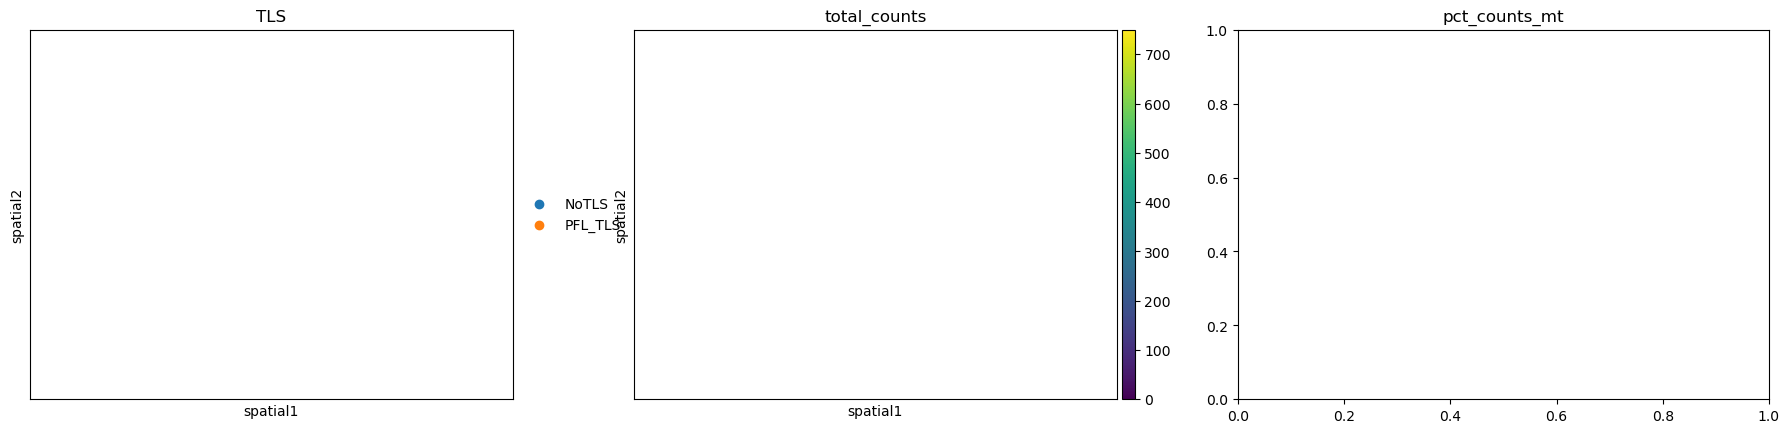

In [18]:
# sc.pl.spatial(
#     adata,
#     color=["TLS", "total_counts", "pct_counts_mt"],
#     size=0.1,
#     cmap="viridis",  # or specify list of colormaps for each
#     ncols=3,         # number of panels per row
#     show=True
# )


In [19]:
# Filter out extremely low-count bins, but keep most signal
sc.pp.filter_cells(adata, min_counts=2)
sc.pp.filter_genes(adata, min_cells=25)
adata

AnnData object with n_obs × n_vars = 677627 × 16444
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'barcode_8um', 'TLS', 'row_8', 'col_8', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id', 'spatial', 'TLS_colors'
    obsm: 'spatial'

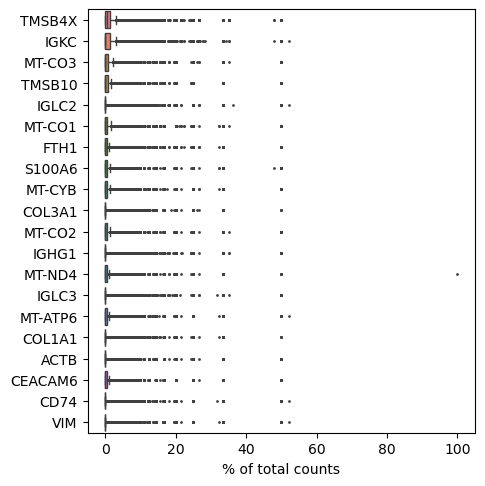

In [20]:
# Normalize and log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# # Plot total counts after normalization
sc.pl.highest_expr_genes(adata, n_top=20)

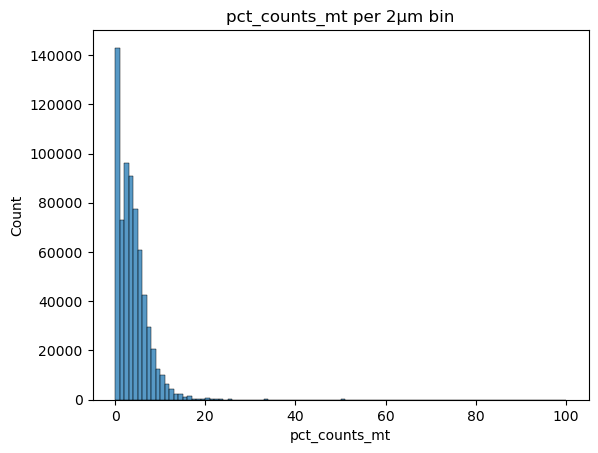

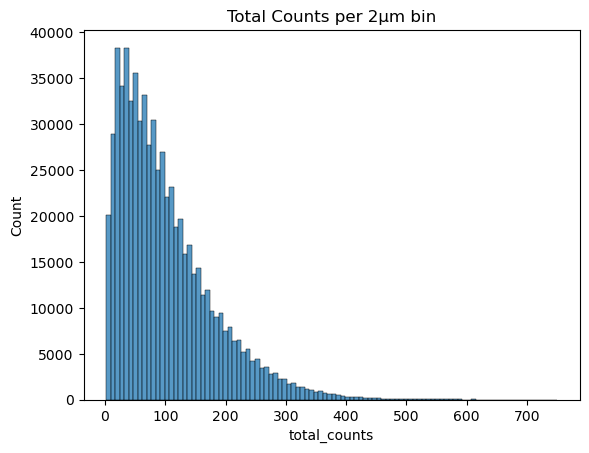

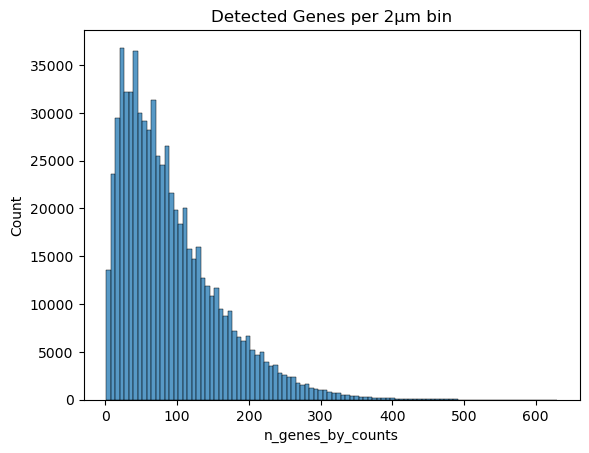

In [24]:
sns.histplot(adata.obs['pct_counts_mt'], bins=100)
plt.title("pct_counts_mt per 2µm bin")
plt.show()

sns.histplot(adata.obs['total_counts'], bins=100)
plt.title("Total Counts per 2µm bin")
plt.show()

sns.histplot(adata.obs['n_genes_by_counts'], bins=100)
plt.title("Detected Genes per 2µm bin")
plt.show()


In [25]:
adata

AnnData object with n_obs × n_vars = 677627 × 16444
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'barcode_8um', 'TLS', 'row_8', 'col_8', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id', 'spatial', 'TLS_colors', 'log1p'
    obsm: 'spatial'

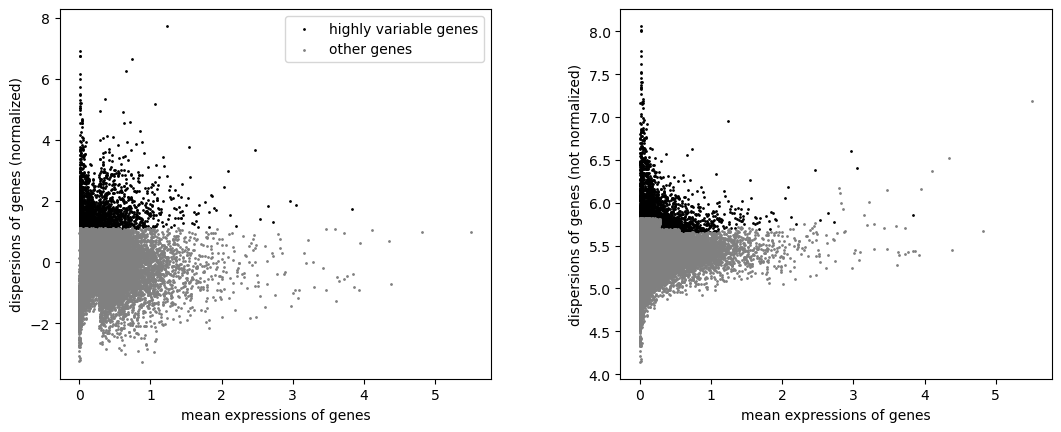

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


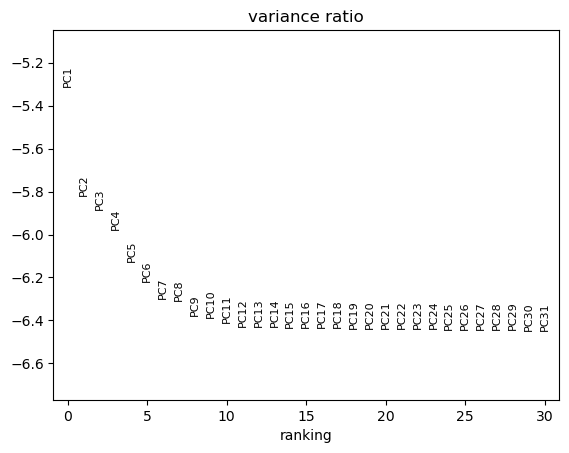

In [26]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)



In [29]:
import time
import scanpy as sc

sc.settings.verbosity = 3  # Show progress

# Step 1: Neighbors
start = time.time()
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=6)
end = time.time()
print(f"\n✅ Neighbors computed in {end - start:.2f} seconds")

# Step 2: Leiden clustering
start = time.time()
sc.tl.leiden(adata, resolution=1)
end = time.time()
print(f"✅ Leiden clustering completed in {end - start:.2f} seconds")
a
# Show object summary
adata


computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)

✅ Neighbors computed in 58.18 seconds
running Leiden clustering
    finished: found 620 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:06:40)
✅ Leiden clustering completed in 400.46 seconds


AnnData object with n_obs × n_vars = 677627 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'barcode_8um', 'TLS', 'row_8', 'col_8', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_id', 'spatial', 'TLS_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
import time
import scanpy as sc

sc.settings.verbosity = 3  # Show progress

# Step 1: Neighbors
start = time.time()
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=6)
end = time.time()
print(f"\n✅ Neighbors computed in {end - start:.2f} seconds")

# Step 2: Leiden clustering
start = time.time()
sc.tl.leiden(adata, resolution=0.5)
end = time.time()
print(f"✅ Leiden clustering completed in {end - start:.2f} seconds")

# Show object summary
adata


computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:57)

✅ Neighbors computed in 57.27 seconds
running Leiden clustering
    finished: found 646 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:08:01)
✅ Leiden clustering completed in 481.51 seconds


NameError: name 'a' is not defined

the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


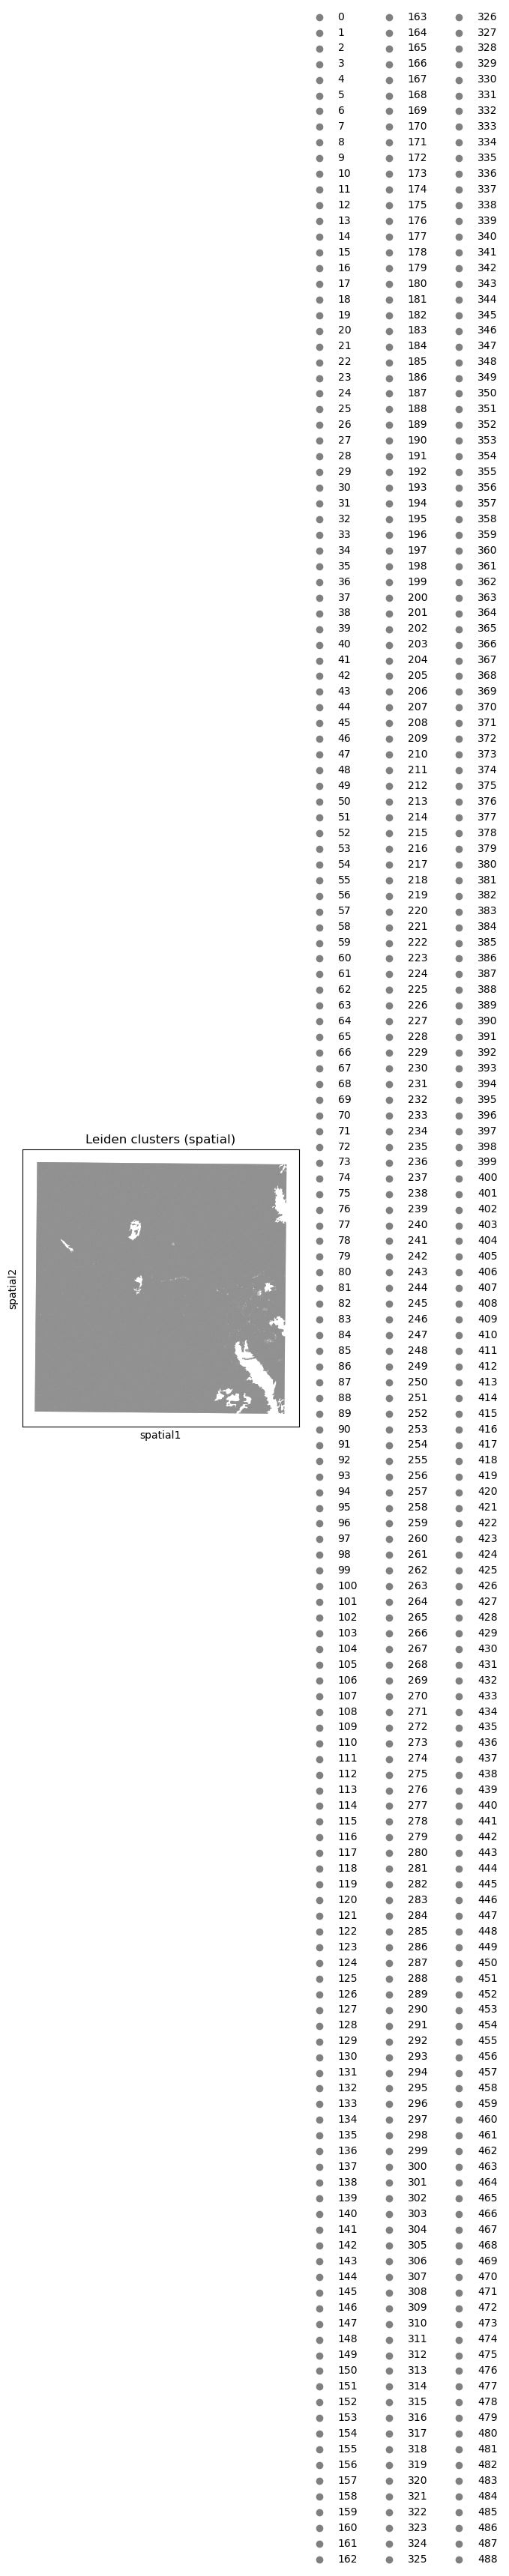

In [28]:
sq.pl.spatial_scatter(adata, color="leiden", size=50, title="Leiden clusters (spatial)", img=False)

In [ ]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=42)
# Visualize clustering
sc.pl.umap(adata, color=["leiden"], title="Leiden clusters")